**In this project we will predict Stock price using RIDGE REGRESSION & DEEP NEURAL NETWORK MODEL (LSTM)**

# Importing libraries

In [1]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow import keras


# Loading Data

In [2]:
stock_price_df= pd.read_csv('/content/stock.csv')
stock_price_df=stock_price_df.sort_values(by= ['Date'])


stock_vol_df= pd.read_csv('/content/stock_volume.csv')
stock_vol_df=stock_vol_df.sort_values(by= ['Date'])

# Checking out data

In [3]:
stock_price_df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [4]:
stock_price_df.isnull().sum()

Date     0
AAPL     0
BA       0
T        0
MGM      0
AMZN     0
IBM      0
TSLA     0
GOOG     0
sp500    0
dtype: int64

In [5]:
stock_price_df.describe()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
count,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000
mean,140.819823,189.942700,35.162899,23.105743,915.665665,161.853001,259.600815,783.712512,2218.749554
std,70.827601,103.678586,3.207490,6.963847,697.838905,25.561938,210.988003,334.448057,537.321727
min,55.790001,67.239998,26.770000,7.140000,175.929993,94.769997,22.790001,278.481171,1278.040039
25%,89.165714,124.015000,33.040001,18.545000,316.490005,142.769997,184.595001,527.214416,1847.984985
50%,116.599998,142.419998,34.930000,23.780001,676.010010,156.949997,231.960007,737.599976,2106.629883
75%,175.019997,297.044998,37.419998,28.430000,1593.645019,185.974998,307.350006,1079.744995,2705.810059
max,455.609985,440.619995,43.470001,38.029999,3225.000000,215.800003,1643.000000,1568.489990,3386.149902


In [6]:
stock_vol_df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,53146800,3934500,26511100,17891100,5385800,6881000,729300,3764400,4019890000
1,2012-01-13,56505400,4641100,22096800,16621800,4753500,5279200,5500400,4631800,3692370000
2,2012-01-17,60724300,3700100,23500200,15480800,5644500,6003400,4651600,3832800,4010490000
3,2012-01-18,69197800,4189500,22015000,18387600,7473500,4600600,1260200,5544000,4096160000
4,2012-01-19,65434600,5397300,25524000,14022900,7096000,8567200,1246300,12657800,4465890000


In [7]:
stock_vol_df.isnull().sum()

Date     0
AAPL     0
BA       0
T        0
MGM      0
AMZN     0
IBM      0
TSLA     0
GOOG     0
sp500    0
dtype: int64

In [8]:
stock_vol_df.describe()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
count,2.159000e+03,2.159000e+03,2.159000e+03,2.159000e+03,2.159000e+03,2.159000e+03,2.159000e+03,2.159000e+03,2.159000e+03
mean,5.820332e+07,6.419916e+06,2.832131e+07,9.845582e+06,4.102673e+06,4.453090e+06,7.001302e+06,2.498238e+06,3.680732e+09
std,4.568141e+07,9.711873e+06,1.428911e+07,7.295753e+06,2.290722e+06,2.462811e+06,5.781208e+06,1.928407e+06,8.622717e+08
min,1.136200e+07,7.889000e+05,6.862400e+06,9.507000e+05,8.813000e+05,1.193000e+06,3.649000e+05,7.900000e+03,1.248960e+09
25%,2.769930e+07,3.031850e+06,2.002150e+07,5.796450e+06,2.675700e+06,3.111250e+06,3.433450e+06,1.325400e+06,3.211890e+09
50%,4.209420e+07,3.991000e+06,2.485930e+07,7.899800e+06,3.494800e+06,3.825000e+06,5.581100e+06,1.813900e+06,3.526890e+09
75%,7.182480e+07,5.325900e+06,3.210565e+07,1.104055e+07,4.768150e+06,4.937300e+06,8.619550e+06,3.245350e+06,3.933290e+09
max,3.765300e+08,1.032128e+08,1.950827e+08,9.009820e+07,2.385610e+07,3.049020e+07,6.093880e+07,2.497790e+07,9.044690e+09


#EDA & Visualization

## Normalizing Data

In [9]:
def normalize(df):
  x=df.copy()
  for i in x.columns[1:]:
    x[i]= x[i]/x[i][0]
  return x

## Visualizing function

In [10]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):
  fig = px.line(title=title)
  for i in df.columns[1:]:
    fig.add_scatter(x= df['Date'], y = df[i], name=i)
  fig.show()

In [11]:
interactive_plot(normalize(stock_price_df), 'Normalized Stock Price')

In [12]:
interactive_plot(normalize(stock_vol_df),'Normalized Stock Volume')

# Preparing Data for creating Model

In [13]:
# Function to concatenate the date, stock price, and volume in one dataframe
def individual_stock(price_df,vol_df,name):
  return pd.DataFrame({'Date': price_df['Date'],'Close':price_df[name], 'Volume': vol_df[name]})
def trading_window(data):
  n=1 #shift price by 1 day
  data['Target']= data[['Close']].shift(-n)
  return data


In [14]:
# Let's test the functions and get individual stock prices and volumes for AAPL

price_volume_df= individual_stock(stock_price_df,stock_vol_df,'AAPL')

In [15]:
price_volume_df

,Date,Close,Volume
0,2012-01-12,60.198570,53146800
1,2012-01-13,59.972858,56505400
2,2012-01-17,60.671429,60724300
3,2012-01-18,61.301430,69197800
4,2012-01-19,61.107143,65434600
...,...,...,...
2154,2020-08-05,440.250000,30498000
2155,2020-08-06,455.609985,50607200
2156,2020-08-07,444.450012,49453300
2157,2020-08-10,450.910004,53100900


In [16]:
price_volume_target_df = trading_window(price_volume_df)
price_volume_target_df

,Date,Close,Volume,Target
0,2012-01-12,60.198570,53146800,59.972858
1,2012-01-13,59.972858,56505400,60.671429
2,2012-01-17,60.671429,60724300,61.301430
3,2012-01-18,61.301430,69197800,61.107143
4,2012-01-19,61.107143,65434600,60.042858
...,...,...,...,...
2154,2020-08-05,440.250000,30498000,455.609985
2155,2020-08-06,455.609985,50607200,444.450012
2156,2020-08-07,444.450012,49453300,450.910004
2157,2020-08-10,450.910004,53100900,437.500000


In [17]:
# Remove the last row as it will be a null value
price_volume_target_df = price_volume_target_df[:-1]
price_volume_target_df

,Date,Close,Volume,Target
0,2012-01-12,60.198570,53146800,59.972858
1,2012-01-13,59.972858,56505400,60.671429
2,2012-01-17,60.671429,60724300,61.301430
3,2012-01-18,61.301430,69197800,61.107143
4,2012-01-19,61.107143,65434600,60.042858
...,...,...,...,...
2153,2020-08-04,438.660004,43267900,440.250000
2154,2020-08-05,440.250000,30498000,455.609985
2155,2020-08-06,455.609985,50607200,444.450012
2156,2020-08-07,444.450012,49453300,450.910004


In [18]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range= (0,1))
price_volume_target_scaled_df =  sc.fit_transform(price_volume_target_df.drop(columns=['Date']))

In [19]:
price_volume_target_scaled_df

array([[0.01102638, 0.11442624, 0.01046185],
       [0.01046185, 0.12362365, 0.01220906],
       [0.01220906, 0.13517696, 0.01378478],
       ...,
       [1.        , 0.10747163, 0.97208751],
       [0.97208751, 0.10431171, 0.98824476],
       [0.98824476, 0.11430054, 0.95470465]])

In [20]:
price_volume_target_scaled_df.shape

(2158, 3)

In [21]:
# Create Feature and Target
x = price_volume_target_scaled_df[:,:2]
y = price_volume_target_scaled_df[:,2:]

In [22]:
x.shape

(2158, 2)

In [23]:
y.shape

(2158, 1)

In [24]:
# Spliting the data this way, since order is important in time-series
# Note that we did not use train test split with it's default settings since it shuffles the data
split= int(0.65 * len(x))
split

1402

In [25]:
X_train=x[:split]
X_train.shape

(1402, 2)

In [26]:
y_train= y[:split]

In [27]:
X_test= x[split:]
y_test= y[split:]

In [28]:
X_test.shape

(756, 2)

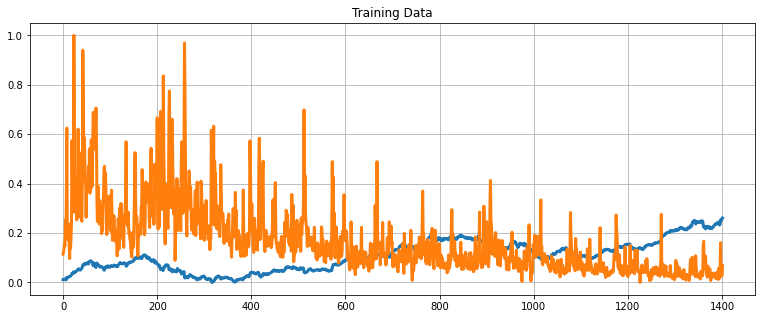

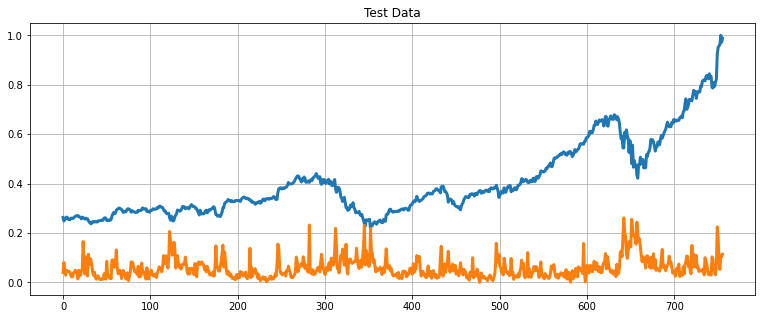

In [29]:
# Define a data plotting function
def show_plot(data,title):
  plt.figure(figsize=(13,5))
  plt.plot(data, linewidth=3)
  plt.title(title)
  plt.grid()
show_plot(X_train, 'Training Data')
show_plot(X_test, 'Test Data')

# RIDGE REGRESSION

In [30]:
from sklearn.linear_model import Ridge
# Note that Ridge regression performs linear least squares with L2 regularization.
# Create and train the Ridge Linear Regression  Model
regression_model = Ridge(alpha=0.5)
regression_model.fit(X_train, y_train)
# Test the model and calculate its accuracy 
lr_accuracy = regression_model.score(X_test,y_test)
print('Ridge Reggression Score:', lr_accuracy)

Ridge Reggression Score: 0.9287228990823156


In [31]:
# Make Prediction
predicted_prices = regression_model.predict(x)
predicted_prices

array([[0.02448073],
       [0.02371272],
       [0.02490474],
       ...,
       [0.89303245],
       [0.86861809],
       [0.88250883]])

In [32]:
# Append the predicted values into a list
predicted= []
for i in predicted_prices:
  predicted.append(i[0])
# Append the close values to the list
close = []
for i in price_volume_target_scaled_df:
  close.append(i[0])


In [33]:
# Create a dataframe based on the dates in the individual stock data
df_predicted = price_volume_target_df[['Date']]
# Add the close values to the dataframe
df_predicted['Close'] = close
# Add the predicted values to the dataframe
df_predicted['Prediction'] = predicted
df_predicted

,Date,Close,Prediction
0,2012-01-12,0.011026,0.024481
1,2012-01-13,0.010462,0.023713
2,2012-01-17,0.012209,0.024905
3,2012-01-18,0.013785,0.025601
4,2012-01-19,0.013299,0.025480
...,...,...,...
2153,2020-08-04,0.957606,0.856404
2154,2020-08-05,0.961583,0.860932
2155,2020-08-06,1.000000,0.893032
2156,2020-08-07,0.972088,0.868618


In [34]:
# Plot the results
interactive_plot(df_predicted, 'Orignal Vs Predictions')

# LSTM TIME SERIES MODEL

In [35]:
# Let's test the functions and get individual stock prices and volumes for AAPL
price_volume_df = individual_stock(stock_price_df, stock_vol_df, 'AAPL')
# Get the close and volume data as training data (Input)
training_data = price_volume_df.iloc[:, 1:3].values
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)
# Create the training and testing data, training data contains present day and previous day values
X = []
y = []
for i in range(1, len(price_volume_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)
# Split the data
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((1510, 1, 1), (648, 1, 1))

In [65]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 150)            91200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 150)            180600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 150)               180600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [68]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
38/38 [==============================] - 0s 11ms/step - loss: 1.7196e-04 - val_loss: 4.7901e-05
Epoch 2/20
38/38 [==============================] - 0s 10ms/step - loss: 5.7652e-05 - val_loss: 1.8555e-05
Epoch 3/20
38/38 [==============================] - 0s 11ms/step - loss: 4.7977e-05 - val_loss: 2.1285e-05
Epoch 4/20
38/38 [==============================] - 0s 11ms/step - loss: 4.2228e-05 - val_loss: 4.3938e-05
Epoch 5/20
38/38 [==============================] - 0s 11ms/step - loss: 3.9994e-05 - val_loss: 1.6796e-05
Epoch 6/20
38/38 [==============================] - 0s 10ms/step - loss: 4.1431e-05 - val_loss: 2.2334e-05
Epoch 7/20
38/38 [==============================] - 0s 10ms/step - loss: 4.0429e-05 - val_loss: 3.3088e-05
Epoch 8/20
38/38 [==============================] - 0s 10ms/step - loss: 3.7666e-05 - val_loss: 1.6939e-05
Epoch 9/20
38/38 [==============================] - 0s 10ms/step - loss: 3.4425e-05 - val_loss: 2.2680e-05
Epoch 10/20
38/38 [==================

In [69]:
# Make prediction
predicted = model.predict(X)
# Append the predicted values to the list
test_predicted = []
for i in predicted:
  test_predicted.append(i[0])
#Append close value to a list
close = []
for i in training_set_scaled:
  close.append(i[0])
df_predicted = price_volume_df[1:][['Date']]
df_predicted['predictions'] = test_predicted
df_predicted['Close'] = close[1:]
df_predicted


,Date,predictions,Close
1,2012-01-13,0.009915,0.010462
2,2012-01-17,0.009349,0.012209
3,2012-01-18,0.011103,0.013785
4,2012-01-19,0.012685,0.013299
5,2012-01-20,0.012197,0.010637
...,...,...,...
2154,2020-08-05,0.940346,0.961583
2155,2020-08-06,0.943982,1.000000
2156,2020-08-07,0.978924,0.972088
2157,2020-08-10,0.953571,0.988245


In [70]:
# Plot the data
interactive_plot(df_predicted, "Original Vs Prediction")